In [26]:
def missing_dates(df):
    # Convert the date column to datetime type if not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Get the first and last date
    first_date = df['Date'].min()
    last_date = df['Date'].max()

    # Generate a sequence of all dates between the first and last date
    all_dates = pd.date_range(start=first_date, end=last_date, freq='D')

    # Find the missing dates
    missing_dates = all_dates[~all_dates.isin(df['Date'])]

    if len(missing_dates) == 0:
        return False
    else:
        return True
    


In [27]:
def metrics(prediction, real_values):
    d = real_values - prediction
    mse_f = np.mean(d**2)
    mae_f = np.mean(abs(d))
    rmse_f = np.sqrt(mse_f)
    r2_f = 1-(sum(d**2)/sum((real_values-np.mean(real_values))**2))

    return mse_f, mae_f, rmse_f, r2_f

In [28]:
def Fill_Data(Demand):

    Demand.set_index('Date', inplace=True)
    # Resample the dataframe to fill in any missing dates with NaN values
    Demand = Demand.resample('D').asfreq()

    Demand['Order_Demand'] = Demand['Order_Demand'].interpolate(method='linear')

    return Demand

In [29]:
def preproc_data(dataset):
 
    dataset_dir='./'+str(dataset)+'.csv'

    Demand_raw = pd.read_csv(dataset_dir)

    Demand_raw['Date'] = pd.to_datetime(Demand_raw['Date'])

    Demand = Demand_raw.groupby('Date')['Order_Demand'].sum().reset_index()
    
    zero_mask = Demand['Order_Demand'] <= 0
    Demand.loc[zero_mask, 'Order_Demand'] = np.nan

    return Demand

        

C:\Users\mmmap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


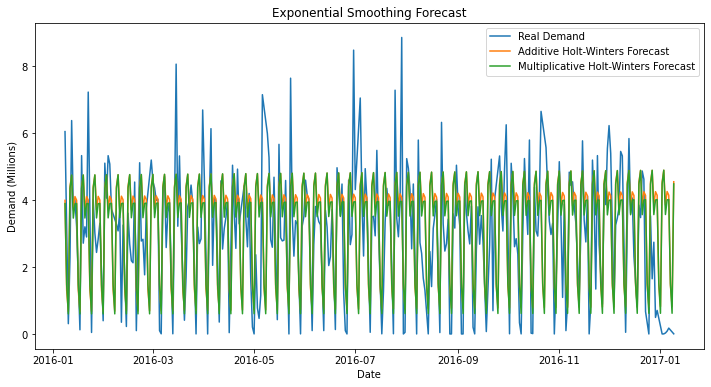

In [30]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


dataset="Demand_Data"  #or "Demand"

Demand = preproc_data(dataset)
# Load the demand data into a DataFrame


if missing_dates(Demand) == True:
    Processed_Demand=Fill_Data(Demand)

else:
    Processed_Demand=Demand

Processed_Demand['Order_Demand'] = Processed_Demand['Order_Demand'] / 1000000


train_size = int(len(Processed_Demand) * 0.8)
train_data = Processed_Demand[:train_size]
test_data = Processed_Demand[train_size:]


train_data = train_data.fillna(train_data.mean())

# Exponential Smoothing (Holt-Winters)
# Additive trend and seasonality
add_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=7)
add_fit = add_model.fit()
add_forecast = add_fit.forecast(len(test_data))

add_forecast = add_forecast

# Multiplicative trend and seasonality
mul_model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=7)
mul_fit = mul_model.fit()
mul_forecast = mul_fit.forecast(len(test_data))

mul_forecast = mul_forecast

name='./Images/Exp_Smooth.png'

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
#plt.plot(train_data.index, train_data.values, label='Train Data')
plt.plot(test_data.index, test_data.values, label='Real Demand')
plt.plot(test_data.index, add_forecast, label='Additive Holt-Winters Forecast')
plt.plot(test_data.index, mul_forecast, label='Multiplicative Holt-Winters Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Demand (Millions)')
plt.title('Exponential Smoothing Forecast')
plt.savefig(name)
plt.show()



In [31]:
Data_ESMOOTH_Lag = pd.DataFrame({'Date': test_data.index, 'Real Demand': test_data.values.flatten(), 'Additive Holt-Winters': add_forecast.values, 'Multiplicative Holt-Winters': mul_forecast.values})

Data_ESMOOTH_Lag.to_csv('./Output/Demand_EXSMOO.csv', index=False)